#ТЗ проекта “Аналитика данных компании Gectaro”
##Описание пректа:
Компания Gectaro продает софт с платной подпиской в сегменте B2B (наиболее частый срок подписки 12-24 месяца), предназначенный для управления процессами в сфере строительства и ремонта.
Основная проблема – это уход из сервиса большого количества подписчиков и не продление подписки.
##Цель проекта:
Проанализировать имеющиеся данные, составить портреты наиболее типичных клиентов, разобраться в причинах оттока клиентов, предложить решения по их минимизации. Для этого предлагается определить ключевые признаки для компаний, наличие которых (или их появление) влияет на отмену (отсутствие оплаты) подписки.



In [7]:
from google.colab import files
uploaded = files.upload()

Saving activities.csv to activities.csv


In [10]:
import pandas as pd
from datetime import datetime,timedelta,date
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np

##Загрузим датасеты  и проведем предобработку данных

In [11]:
df = pd.read_csv("activities.csv",index_col=0)#загружаем файл активностей компаний
df.head()

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
0,1,2019-09-01 00:00:00+00:00,1.0,0.0,0.0,7.0,0.0,0.0
1,1,2019-12-01 00:00:00+00:00,1.0,0.0,0.0,2.0,1.0,0.0
2,1,2020-04-01 00:00:00+00:00,4.0,1.0,0.0,1.0,6.0,0.0
3,1,2020-07-01 00:00:00+00:00,1.0,7.0,3.0,5.0,0.0,0.0
4,21,2020-01-01 00:00:00+00:00,3.0,0.0,0.0,1.0,0.0,0.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6316 entries, 0 to 6556
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   company_id                     6316 non-null   int64  
 1   month                          6316 non-null   object 
 2   company-month-billing          6316 non-null   float64
 3   company-month-stocks           6316 non-null   float64
 4   company-month-backups          6316 non-null   float64
 5   company-month-projects         6316 non-null   float64
 6   company-month-contractors      6316 non-null   float64
 7   company-month-resource_orders  6316 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 702.1+ KB


In [13]:
df['month'] = pd.to_datetime(df['month'], format='ISO8601')#приводим к необходимому формату столбец
df.head()

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
0,1,2019-09-01 00:00:00+00:00,1.0,0.0,0.0,7.0,0.0,0.0
1,1,2019-12-01 00:00:00+00:00,1.0,0.0,0.0,2.0,1.0,0.0
2,1,2020-04-01 00:00:00+00:00,4.0,1.0,0.0,1.0,6.0,0.0
3,1,2020-07-01 00:00:00+00:00,1.0,7.0,3.0,5.0,0.0,0.0
4,21,2020-01-01 00:00:00+00:00,3.0,0.0,0.0,1.0,0.0,0.0


In [14]:
df['month'] = df['month'].apply(lambda x: x.strftime('%Y-%m'))
df['month'] = pd.to_datetime(df['month'], format='%Y-%m')#убираем  лишнее
df.head()

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
0,1,2019-09-01,1.0,0.0,0.0,7.0,0.0,0.0
1,1,2019-12-01,1.0,0.0,0.0,2.0,1.0,0.0
2,1,2020-04-01,4.0,1.0,0.0,1.0,6.0,0.0
3,1,2020-07-01,1.0,7.0,3.0,5.0,0.0,0.0
4,21,2020-01-01,3.0,0.0,0.0,1.0,0.0,0.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6316 entries, 0 to 6556
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   company_id                     6316 non-null   int64         
 1   month                          6316 non-null   datetime64[ns]
 2   company-month-billing          6316 non-null   float64       
 3   company-month-stocks           6316 non-null   float64       
 4   company-month-backups          6316 non-null   float64       
 5   company-month-projects         6316 non-null   float64       
 6   company-month-contractors      6316 non-null   float64       
 7   company-month-resource_orders  6316 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 702.1 KB


In [16]:
print(df.duplicated().sum())#смотрим явные дубликаты

0


In [17]:
df.isna().sum()#смотрим пропуски

company_id                       0
month                            0
company-month-billing            0
company-month-stocks             0
company-month-backups            0
company-month-projects           0
company-month-contractors        0
company-month-resource_orders    0
dtype: int64

In [18]:
from google.colab import files
uploaded = files.upload()

Saving companies.csv to companies.csv


In [19]:
df_сomp = pd.read_csv("companies.csv",index_col=0)#загружаем файл с данными о компаниях

df_сomp.head()

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
19,514,-,1.0,1571316635,1670298314,4.0,True
57,383,Строительство,2.0,1564142565,1676550050,7.0,False
69,495,-,1.0,1570535695,1598281714,2.0,False
75,724,-,1.0,1579514393,1670298294,4.0,True
99,471,-,1.0,1569328017,1670298360,7.0,True


In [20]:
df_сomp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 723 entries, 19 to 17972
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       723 non-null    int64  
 1   working_direction        720 non-null    object 
 2   employer_count_interval  723 non-null    float64
 3   created_at               723 non-null    int64  
 4   updated_at               723 non-null    int64  
 5   billing_tariff_id        716 non-null    float64
 6   billing_is_over          723 non-null    bool   
dtypes: bool(1), float64(2), int64(3), object(1)
memory usage: 40.2+ KB


In [21]:
df_сomp['created_at'] = pd.to_datetime(df_сomp['created_at'],unit = 's')#нужный формат даты
df_сomp['updated_at'] = pd.to_datetime(df_сomp['updated_at'],unit = 's')
df_сomp.head()

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
19,514,-,1.0,2019-10-17 12:50:35,2022-12-06 03:45:14,4.0,True
57,383,Строительство,2.0,2019-07-26 12:02:45,2023-02-16 12:20:50,7.0,False
69,495,-,1.0,2019-10-08 11:54:55,2020-08-24 15:08:34,2.0,False
75,724,-,1.0,2020-01-20 09:59:53,2022-12-06 03:44:54,4.0,True
99,471,-,1.0,2019-09-24 12:26:57,2022-12-06 03:46:00,7.0,True


In [22]:
print(df_сomp.duplicated().sum())

0


In [23]:
df_сomp.isna().sum()#проверяем пропуски

id                         0
working_direction          3
employer_count_interval    0
created_at                 0
updated_at                 0
billing_tariff_id          7
billing_is_over            0
dtype: int64

In [25]:
df_сomp['billing_tariff_id'].unique()# смотрим какие тарифы есть у компаний

array([ 4.,  7.,  2.,  3.,  9.,  6., 10., nan, 13., 11., 20., 17., 21.,
       19.])

In [26]:
df_сomp=df_сomp.dropna(subset=['billing_tariff_id']).reset_index(drop=True)#удаляем строки ,где тарифов нет
df_сomp['id'].nunique()


716

С пропусками в столбцах с направлением деятельности компании ничего делать не будем

In [27]:
from google.colab import files
uploaded = files.upload()

Saving people.csv to people.csv


In [28]:
df_pl = pd.read_csv("people.csv",index_col=0)

df_pl.head()

,id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at
2,6601,495,NaN,7133,1570535962,1570535962,True,1.594067e+09
6,7025,1,NaN,1,1594120484,1594120484,True,1.594120e+09
7,7165,1255,1734.0,18085,1595438102,1595439391,True,1.633960e+09
10,7130,1470,1703.0,1,1595234824,1595234824,False,NaN
17,7163,1492,1731.0,1,1595429211,1598540644,True,1.620195e+09


In [29]:
df_pl['created_at'] = pd.to_datetime(df_pl['created_at'],unit = 's')
df_pl['updated_at'] = pd.to_datetime(df_pl['updated_at'],unit = 's')
df_pl['deleted_at'] = pd.to_datetime(df_pl['deleted_at'],unit = 's')


In [30]:
df_pl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5095 entries, 2 to 17054
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          5095 non-null   int64         
 1   company_id  5095 non-null   int64         
 2   user_id     3813 non-null   float64       
 3   role_id     5095 non-null   int64         
 4   created_at  5095 non-null   datetime64[ns]
 5   updated_at  5095 non-null   datetime64[ns]
 6   is_deleted  5095 non-null   bool          
 7   deleted_at  2180 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](3), float64(1), int64(3)
memory usage: 323.4 KB


In [31]:
print(df_pl.duplicated().sum())#дубликаты проверяем

0


In [32]:
df_pl.isna().sum()#пропуски

id               0
company_id       0
user_id       1282
role_id          0
created_at       0
updated_at       0
is_deleted       0
deleted_at    2915
dtype: int64

С пропусками ничего делать не будем , на исследование они влиять не будут.

In [33]:
from google.colab import files
uploaded = files.upload()

Saving billing.csv to billing.csv


In [34]:
df_bill = pd.read_csv("billing.csv",index_col=0)#загрузим таблицу всех платежей компаний

df_bill.head()

,Unnamed: 0,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
4,4,3050,567,512,3,1640153302,False,1608617302,1608617302,12.0,NaN,NaN
6,6,3051,2861,2474,7,1640131200,True,1608626162,1608626181,23.0,NaN,1.608626e+09
16,16,3059,1902,1645,2,1616577484,False,1608801484,1608801484,6.0,NaN,NaN
18,18,3065,2352,2035,7,1643500799,False,1608883175,1608883175,23.0,NaN,NaN
24,24,3062,1074,926,3,1611964800,True,1608814072,1608899674,9.0,NaN,1.609200e+09


In [35]:
df_bill.drop('Unnamed: 0', axis= 1 , inplace= True )
df_bill.head()

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
4,3050,567,512,3,1640153302,False,1608617302,1608617302,12.0,NaN,NaN
6,3051,2861,2474,7,1640131200,True,1608626162,1608626181,23.0,NaN,1.608626e+09
16,3059,1902,1645,2,1616577484,False,1608801484,1608801484,6.0,NaN,NaN
18,3065,2352,2035,7,1643500799,False,1608883175,1608883175,23.0,NaN,NaN
24,3062,1074,926,3,1611964800,True,1608814072,1608899674,9.0,NaN,1.609200e+09


In [36]:
print(df_bill.duplicated().sum())#проверим на дубликаты

0


In [37]:
df_bill.isna().sum()

id                            0
user_id                       0
company_id                    0
billing_tariff_id             0
payed_until                   0
is_payed                      0
created_at                    0
updated_at                    0
billing_tariff_price_id       0
comment                    2735
pay_date                   2372
dtype: int64

Пропуски есть в комментариях, с этим ничего делать не будем. Есть пропуски в дате платежей. Из условия ТЗ есть информация, что столбцы с отметками о платежах не являеются достоверными. В связи с этим будем руководствоваться данными из столбца о подписках (до какой даты, до той компания остается в сервисе, не считается ушедшей).

In [38]:
df_bill['payed_until'] = pd.to_datetime(df_bill['payed_until'],unit = 's')
df_bill['created_at'] = pd.to_datetime(df_bill['created_at'],unit = 's')
df_bill['updated_at'] = pd.to_datetime(df_bill['updated_at'],unit = 's')
df_bill['pay_date'] = pd.to_datetime(df_bill['pay_date'],unit = 's')
df_bill.head()

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
4,3050,567,512,3,2021-12-22 06:08:22,False,2020-12-22 06:08:22,2020-12-22 06:08:22,12.0,NaN,NaT
6,3051,2861,2474,7,2021-12-22 00:00:00,True,2020-12-22 08:36:02,2020-12-22 08:36:21,23.0,NaN,2020-12-22 08:36:21
16,3059,1902,1645,2,2021-03-24 09:18:04,False,2020-12-24 09:18:04,2020-12-24 09:18:04,6.0,NaN,NaT
18,3065,2352,2035,7,2022-01-29 23:59:59,False,2020-12-25 07:59:35,2020-12-25 07:59:35,23.0,NaN,NaT
24,3062,1074,926,3,2021-01-30 00:00:00,True,2020-12-24 12:47:52,2020-12-25 12:34:34,9.0,NaN,2020-12-29 00:00:00


In [39]:
df_bill['payed_until'] = df_bill['payed_until'].apply(lambda x: x.strftime('%Y-%m-%d'))
df_bill['payed_until'] = pd.to_datetime(df_bill['payed_until'], format='%Y-%m-%d')
df_bill['created_at'] = df_bill['created_at'].apply(lambda x: x.strftime('%Y-%m-%d'))
df_bill['created_at'] = pd.to_datetime(df_bill['created_at'], format='%Y-%m-%d')
df_bill.head()

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
4,3050,567,512,3,2021-12-22,False,2020-12-22,2020-12-22 06:08:22,12.0,NaN,NaT
6,3051,2861,2474,7,2021-12-22,True,2020-12-22,2020-12-22 08:36:21,23.0,NaN,2020-12-22 08:36:21
16,3059,1902,1645,2,2021-03-24,False,2020-12-24,2020-12-24 09:18:04,6.0,NaN,NaT
18,3065,2352,2035,7,2022-01-29,False,2020-12-25,2020-12-25 07:59:35,23.0,NaN,NaT
24,3062,1074,926,3,2021-01-30,True,2020-12-24,2020-12-25 12:34:34,9.0,NaN,2020-12-29 00:00:00


In [40]:
df_bill.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3480 entries, 4 to 18953
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       3480 non-null   int64         
 1   user_id                  3480 non-null   int64         
 2   company_id               3480 non-null   int64         
 3   billing_tariff_id        3480 non-null   int64         
 4   payed_until              3480 non-null   datetime64[ns]
 5   is_payed                 3480 non-null   bool          
 6   created_at               3480 non-null   datetime64[ns]
 7   updated_at               3480 non-null   datetime64[ns]
 8   billing_tariff_price_id  3480 non-null   float64       
 9   comment                  745 non-null    object        
 10  pay_date                 1108 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](4), float64(1), int64(4), object(1)
memory usage: 302.5+ KB


In [ ]:
df_bill.isna().sum()

id                            0
user_id                       0
company_id                    0
billing_tariff_id             0
payed_until                   0
is_payed                      0
created_at                    0
updated_at                    0
billing_tariff_price_id       0
comment                    2735
pay_date                   2372
year                          0
index                         0
dtype: int64

Пропуски есть в комментариях и дате платежа.Поскольку дата платежа является по видимому не обязательной ,будем ориентироваться на дату подписки в исследованиях. С пропусками ничего делать не будем.

##Исследовательский анализ данных

Посмотрим активность компаний в динамике. Для этого посчитаем сумму актвностей компаний по каждому виду (счета,аренда склада,проекты и пр.) по месяцам. Построим график для каждой активности.

In [41]:
df_din = df.groupby(['month'], \
                        as_index = False)[['company-month-billing','company-month-stocks', \
                                           'company-month-backups','company-month-projects', \
                                           'company-month-contractors','company-month-resource_orders']].sum().sort_values(by='month')#группируем по месяцам -общее кол-во счетов
df_din.head()

,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
0,2019-01-01,0.0,0.0,0.0,4.0,5.0,0.0
1,2019-02-01,0.0,0.0,0.0,1.0,1.0,0.0
2,2019-03-01,0.0,0.0,0.0,1.0,0.0,0.0
3,2019-04-01,0.0,0.0,0.0,0.0,1.0,0.0
4,2019-05-01,0.0,0.0,0.0,14.0,26.0,0.0


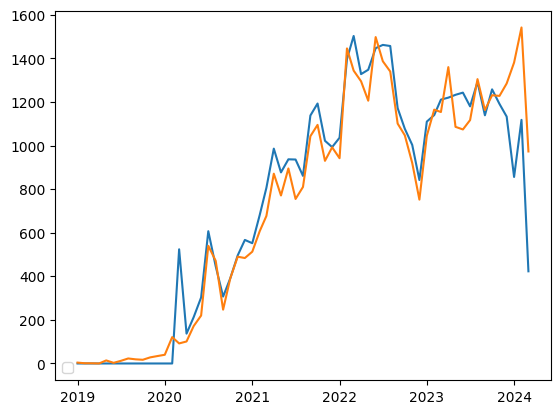

In [43]:
x = df_din['month']
y = df_din['company-month-backups']
y2 = df_din['company-month-stocks']
y3 = df_din['company-month-projects']

plt.plot(x,y2)
plt.plot(x,y3)
plt.legend(loc=3)

plt.show()

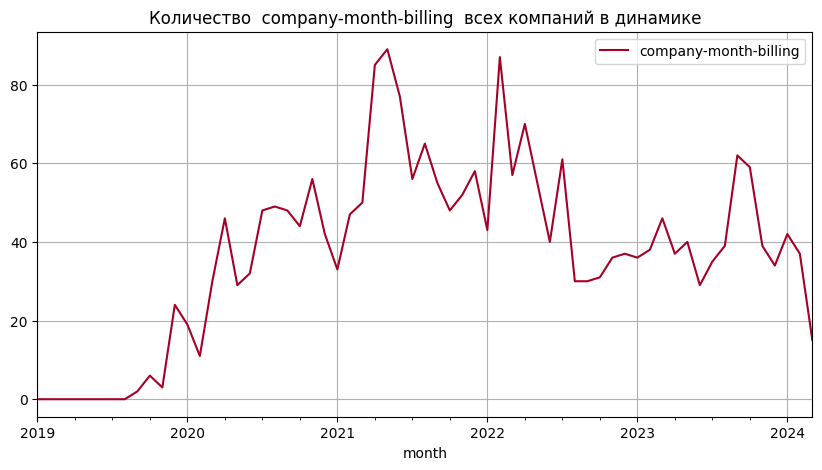

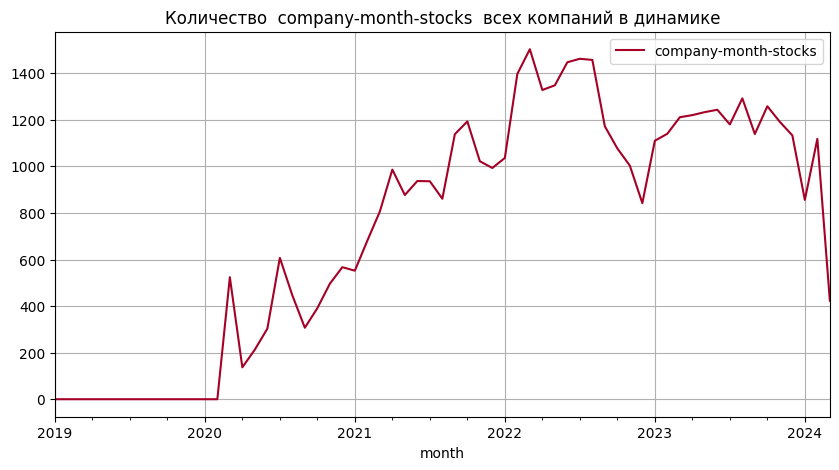

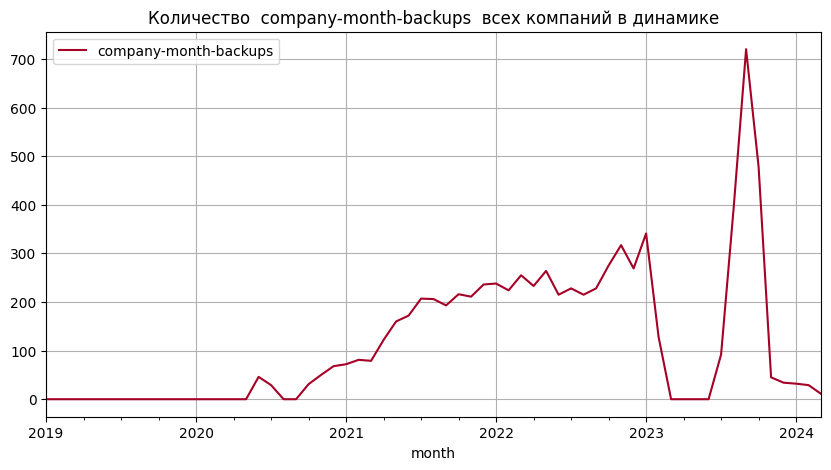

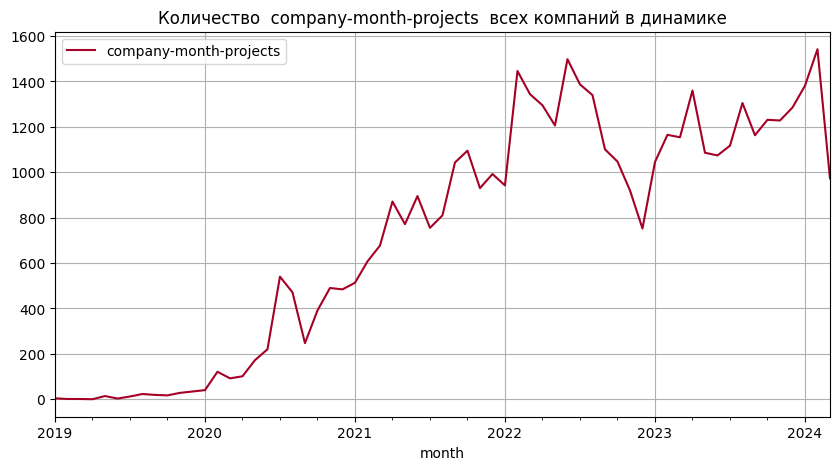

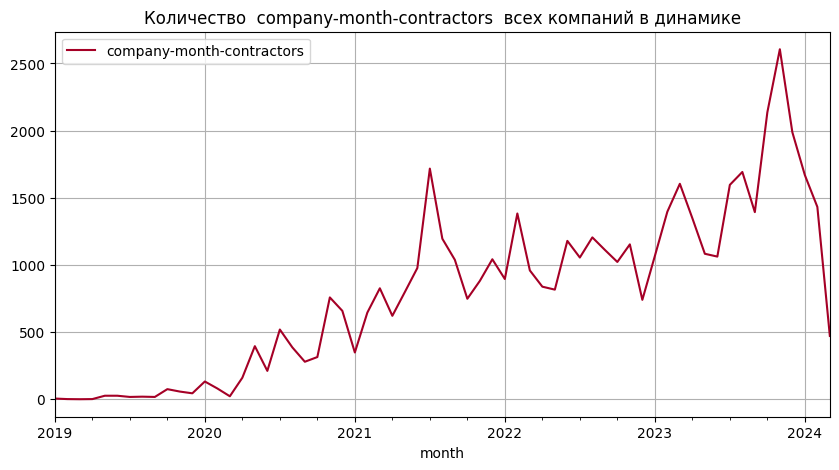

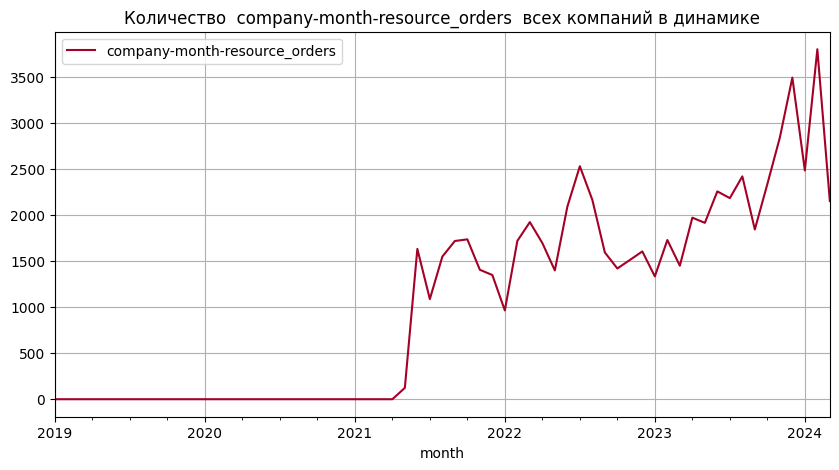

In [44]:
for col in df_din.columns[1:]:
    df_din.plot(x='month',y=col,cmap='RdYlBu',title=('Количество  {}  всех компаний в динамике').format(col),grid=True, figsize=(10,5))

Из графиков видно ,что совокупная активность компаний упала в настоящее время

Посмотрим сколько компаний в датасете

In [ ]:
df['company_id'].nunique()#кол-во компаний

Сгруппируем по уникальным номерам компаний

In [46]:
df_act = df.groupby(['company_id'], \
                        as_index = False)[['company-month-billing','company-month-stocks', \
                                           'company-month-backups','company-month-projects', \
                                           'company-month-contractors','company-month-resource_orders']].sum().sort_values(by='company-month-billing',ascending=False)#группируем по компаниям -общее кол-во счетов



df_act.head() #получаем таблицу с суммой всех активностей для каждой компании

,company_id,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
64,981,29.0,897.0,0.0,898.0,111.0,56.0
252,3277,28.0,100.0,0.0,100.0,10.0,28.0
59,926,21.0,378.0,0.0,377.0,287.0,208.0
32,628,21.0,115.0,0.0,115.0,30.0,0.0
1,21,21.0,84.0,0.0,83.0,127.0,15.0


Добавим столбец -суммарная активность

In [47]:
df_act['activ_total']= df_act['company-month-billing']+ df_act['company-month-stocks']+df_act['company-month-projects']+df_act['company-month-resource_orders']+df_act['company-month-contractors']


In [48]:
df_act.rename(columns = {'company-month-backups':'backups_sum'},inplace = True )#переименум столбец


In [49]:
df_act = df_act[['company_id','activ_total','backups_sum']]
df_act.head()

,company_id,activ_total,backups_sum
64,981,1991.0,0.0
252,3277,266.0,0.0
59,926,1271.0,0.0
32,628,281.0,0.0
1,21,330.0,0.0


Датасет с активностями подготовлен для обьединения с другими.

In [50]:
df_сomp['id'].nunique()

716

Добавим столбец с группой тарифа в датасет Компании

In [52]:
tariff_start = [4, 7, 8, 11, 19]#номера тарифов берем из данных
tariff_base = [2,17]
tariff_business = [9,20]
tariff_prof = [3, 10, 13, 21]

In [53]:
df_сomp['tariff_group'] = 'другое'
df_сomp.loc[df_сomp.query('billing_tariff_id == @tariff_start').index, 'tariff_group'] = 'старт'
df_сomp.loc[df_сomp.query('billing_tariff_id == @tariff_base').index, 'tariff_group'] = 'базовый'
df_сomp.loc[df_сomp.query('billing_tariff_id == @tariff_business').index, 'tariff_group'] = 'бизнес'
df_сomp.loc[df_сomp.query('billing_tariff_id == @tariff_prof').index, 'tariff_group'] = 'профи'

In [54]:
df_сomp.rename(columns = {'id':'company_id' }, inplace = True )#переименум столбец с id компаний


In [55]:
df_сomp.groupby(['billing_tariff_id'], \
           as_index = False)['company_id'].count().sort_values(by='company_id',ascending=False)#наиболее распространен базовый тариф 2 и  стартовый 7

,billing_tariff_id,company_id
0,2.0,321
4,7.0,266
5,9.0,46
2,4.0,36
1,3.0,11
9,17.0,9
6,10.0,7
3,6.0,6
11,20.0,5
8,13.0,4


Постороим график количества компаний по группам тарифов

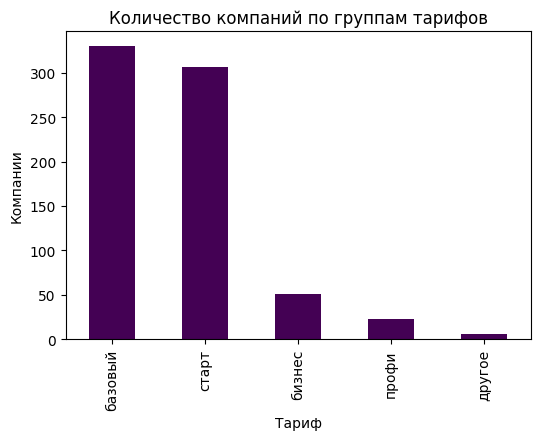

In [56]:
(df_сomp
        .groupby('tariff_group', as_index=False).agg({'company_id': 'count'}).sort_values(by='company_id',ascending=False)
        .plot.bar(x='tariff_group', y='company_id', cmap='viridis', figsize=(6, 4), legend=False)
)
#plt.grid()
plt.title("Количество компаний по группам тарифов")
plt.xlabel("Тариф")
plt.ylabel("Компании")
plt.show()

Сгруппируем компании в зависимости от количества сотрудников,построим график.

In [57]:
df_сomp.groupby(['employer_count_interval'], \
                        as_index = False)['company_id'].count().sort_values(by='company_id',ascending=False)

,employer_count_interval,company_id
0,1.0,492
1,2.0,146
2,3.0,46
3,4.0,14
4,5.0,9
7,8.0,4
6,7.0,3
5,6.0,2


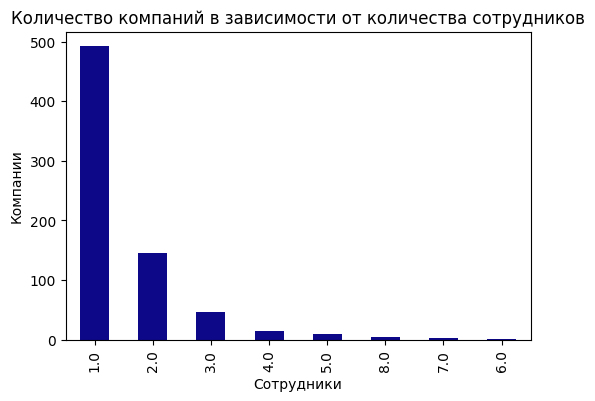

In [58]:
(df_сomp
        .groupby('employer_count_interval', as_index=False).agg({'company_id': 'count'}).sort_values(by='company_id',ascending=False)
        .plot.bar(x='employer_count_interval', y='company_id', cmap='plasma', figsize=(6, 4), legend=False)
)
plt.title("Количество компаний в зависимости от количества сотрудников")
plt.xlabel("Сотрудники")
plt.ylabel("Компании")
plt.show()

In [59]:
df_сomp['working_direction'].unique()#посмотрим чем заняты компании и  заменим некоторые названия в столбце

array(['-', 'Строительство', 'Генеральный подрядчик',
       'Строительная компания', 'Ремонт помещений', 'строительство ',
       'ремонт и отделка', 'СТРОИТЕЛЬСТВО', 'строительство',
       'Строительство домов', 'телемаркетинг', 'ремонт',
       'Ремонт и отделка помещений', '-Малоэтажное строительство',
       'Отделка ', 'Отделка',
       'Проектирование и строительство ресторанов ',
       'строительство  и отделка', 'Электромонтажные работы',
       'строительная компания (тест)', 'Строительство и ремонт',
       'Демонтажные работы', 'Строительство рыбоводных ферм',
       'Строительно-монтажные работы', 'Строительство каркасных домов',
       'Дизайн интерьеров', 'Ремонтные работы',
       'Малоэтажное строительство ', nan, 'Ремонтно-строительная ',
       'Ремонт под ключ', 'Электромонтаж',
       'Проектирование,  Производство и Строительство',
       'Строительство коттеджей', 'Строительство загородных домов',
       'Малоэтажное строительство', 'Электроэнергетика ',
      

In [60]:
df_сomp['working_direction'] = df_сomp['working_direction'].str.replace('СТРОИТЕЛЬСТВО','Строительство',regex=True)
df_сomp['working_direction'] = df_сomp['working_direction'].str.replace('строительство','Строительство',regex=True)
df_сomp['working_direction'] = df_сomp['working_direction'].str.replace('-строительство','Строительство',regex=True)
df_сomp['working_direction'] = df_сomp['working_direction'].str.replace('-Строительство','Строительство',regex=True)
df_сomp['working_direction'] = df_сomp['working_direction'].str.replace('ремонт','Ремонт',regex=True)
df_сomp['working_direction'] = df_сomp['working_direction'].str.replace('-Ремонт','Ремонт',regex=True)
df_сomp['working_direction'] = df_сomp['working_direction'].str.replace('Ремонты','Ремонт',regex=True)

In [ ]:
df_сomp['working_direction'].unique()

Добавим в датасет признак-Ремонт (компания занимается ремонтом )

In [61]:
df_сomp['Ремонт'] = np.where((df_сomp['working_direction'].str.contains('Ремонт')) | (df_сomp['working_direction'].str.contains('Ремонтно'))\
                                   | (df_сomp['working_direction'].str.contains('Ремонтная')), 1, 0)
df_сomp.head()

,company_id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over,tariff_group,Ремонт
0,514,-,1.0,2019-10-17 12:50:35,2022-12-06 03:45:14,4.0,True,старт,0
1,383,Строительство,2.0,2019-07-26 12:02:45,2023-02-16 12:20:50,7.0,False,старт,0
2,495,-,1.0,2019-10-08 11:54:55,2020-08-24 15:08:34,2.0,False,базовый,0
3,724,-,1.0,2020-01-20 09:59:53,2022-12-06 03:44:54,4.0,True,старт,0
4,471,-,1.0,2019-09-24 12:26:57,2022-12-06 03:46:00,7.0,True,старт,0


Добавим в датасет признак-Стройка(компания занимается строительством)

In [62]:
df_сomp['Стройка'] = np.where((df_сomp['working_direction'].str.contains('Строительство')) | (df_сomp['working_direction'].str.contains('Строительно'))\
                                   | (df_сomp['working_direction'].str.contains('строительству')), 1, 0)
df_сomp.head()

,company_id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over,tariff_group,Ремонт,Стройка
0,514,-,1.0,2019-10-17 12:50:35,2022-12-06 03:45:14,4.0,True,старт,0,0
1,383,Строительство,2.0,2019-07-26 12:02:45,2023-02-16 12:20:50,7.0,False,старт,0,1
2,495,-,1.0,2019-10-08 11:54:55,2020-08-24 15:08:34,2.0,False,базовый,0,0
3,724,-,1.0,2020-01-20 09:59:53,2022-12-06 03:44:54,4.0,True,старт,0,0
4,471,-,1.0,2019-09-24 12:26:57,2022-12-06 03:46:00,7.0,True,старт,0,0


In [63]:
df_сomp = df_сomp[['company_id','working_direction','employer_count_interval','created_at','billing_tariff_id','tariff_group','Стройка','Ремонт']]#оставим необходимые столбцы

In [64]:
df_сomp['created_at'] = df_сomp['created_at'].apply(lambda x: x.strftime('%Y-%m-%d'))#оставим только дату
df_сomp['created_at'] = pd.to_datetime(df_сomp['created_at'], format='%Y-%m-%d')


In [65]:
df_сomp.head()

,company_id,working_direction,employer_count_interval,created_at,billing_tariff_id,tariff_group,Стройка,Ремонт
0,514,-,1.0,2019-10-17,4.0,старт,0,0
1,383,Строительство,2.0,2019-07-26,7.0,старт,1,0
2,495,-,1.0,2019-10-08,2.0,базовый,0,0
3,724,-,1.0,2020-01-20,4.0,старт,0,0
4,471,-,1.0,2019-09-24,7.0,старт,0,0


Датасет Компании готов к дальнейшему обьединению.

 В датасете Сотрудники проведем группировку по столбцу company_id и посчитаем должности в каждой компании. Это будет один из количественных признаков в нашем исследовании.

In [66]:
df_pl_rol = df_pl.groupby(['company_id'], \
                        as_index = False)[['role_id']].count().sort_values(by='role_id',ascending=False)
df_pl_rol.head()

,company_id,role_id
547,6806,55
280,3518,54
87,1255,48
289,3623,47
602,7527,45


Добавим столбец с годом и посмотрим на графике динамику тарифов по годам.

In [67]:
df_bill['year'] =  df_bill['payed_until'].dt.year


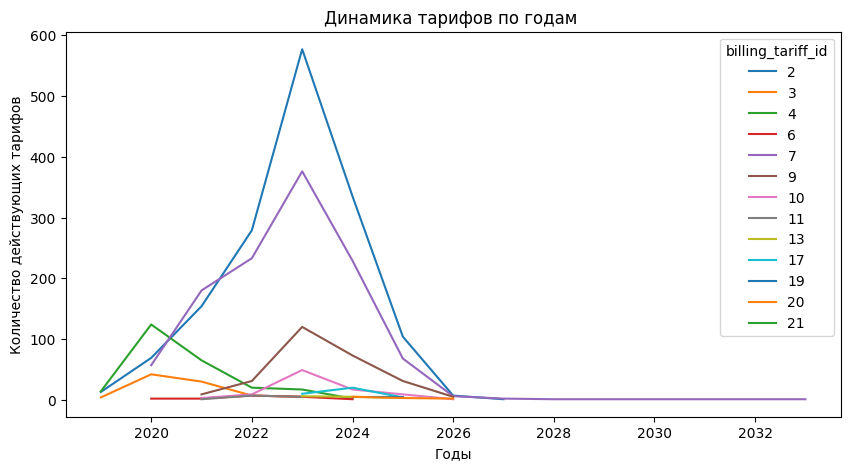

In [68]:
(df_bill
     .pivot_table(index='year',columns='billing_tariff_id',values='company_id',aggfunc='count')
     .plot(title='Динамика тарифов по годам ',figsize=(10, 5))
)
plt.ylabel("Количество действующих тарифов")
plt.xlabel("Годы")
plt.show()

По ТЗ подписка считается действующей ,если она распространяется на дату после 28.03.2024

In [69]:
df_bill['index'] = np.where(df_bill['payed_until']>'2024-3-28', 1, 0)#добвим столбец о наличии действующей подписки.Если 1 подписка действующая
df_bill.head()

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,year,index
4,3050,567,512,3,2021-12-22,False,2020-12-22,2020-12-22 06:08:22,12.0,NaN,NaT,2021,0
6,3051,2861,2474,7,2021-12-22,True,2020-12-22,2020-12-22 08:36:21,23.0,NaN,2020-12-22 08:36:21,2021,0
16,3059,1902,1645,2,2021-03-24,False,2020-12-24,2020-12-24 09:18:04,6.0,NaN,NaT,2021,0
18,3065,2352,2035,7,2022-01-29,False,2020-12-25,2020-12-25 07:59:35,23.0,NaN,NaT,2022,0
24,3062,1074,926,3,2021-01-30,True,2020-12-24,2020-12-25 12:34:34,9.0,NaN,2020-12-29 00:00:00,2021,0


<Axes: >

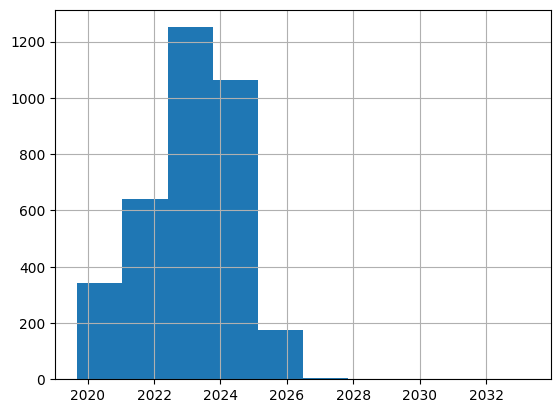

In [70]:
df_bill['payed_until'].hist()#распределение дат ,до которой действует  подписка .Есть выбросы

<Axes: xlabel='payed_until'>

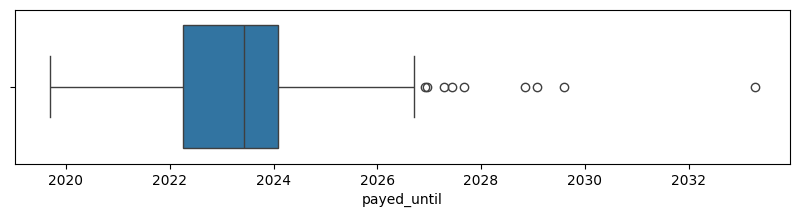

In [71]:
plt.figure(figsize=(10, 2))
sns.boxplot(df_bill['payed_until'], orient='h')

In [72]:
df_bill['payed_until'].describe()

count                             3480
mean     2023-02-27 12:48:24.827586048
min                2019-09-11 00:00:00
25%                2022-04-06 00:00:00
50%                2023-06-04 12:00:00
75%                2024-01-30 00:00:00
max                2033-04-10 00:00:00
Name: payed_until, dtype: object

In [ ]:
df_bill['billing_tariff_id'].unique()#проверим ,не должны входить пробные тарифы 1,18,22.

Чтобы выявить сегмент клиентов ,склонных к оттоку проведем RFM анализ ,точнее RF ,так как данных о сумм платежей у нас нет. Оставим столбцы ,которые для этого пригодятся

In [74]:
df_bill = df_bill[['company_id','billing_tariff_id','payed_until','index']]
df_bill.head()

,company_id,billing_tariff_id,payed_until,index
4,512,3,2021-12-22,0
6,2474,7,2021-12-22,0
16,1645,2,2021-03-24,0
18,2035,7,2022-01-29,0
24,926,3,2021-01-30,0


In [75]:
df_bill.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3480 entries, 4 to 18953
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   company_id         3480 non-null   int64         
 1   billing_tariff_id  3480 non-null   int64         
 2   payed_until        3480 non-null   datetime64[ns]
 3   index              3480 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 135.9 KB


In [76]:
df_bill.groupby(['company_id'],as_index = False)[['payed_until']].count().sort_values(by='payed_until',ascending=False)

,company_id,payed_until
408,3276,61
613,4004,40
1,5,31
1563,6939,30
403,3260,29
...,...,...
766,4446,1
765,4445,1
764,4443,1
763,4442,1


In [77]:
df_bill.loc[df_bill['payed_until'] > '2026-12-1']#эти подписки считаем выбросами


,company_id,billing_tariff_id,payed_until,index
346,512,7,2033-04-10,1
1833,512,2,2026-12-05,1
4000,767,7,2029-08-07,1
5299,694,3,2029-02-01,1
7871,2462,7,2027-09-03,1
12990,7970,7,2028-11-03,1
12992,8432,7,2027-04-13,1
12998,7970,9,2026-12-14,1
12999,7970,2,2027-06-08,1


In [79]:
bill = df_bill.loc[df_bill['payed_until'] < '2026-12-05']#убираем их


In [80]:
bill.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3471 entries, 4 to 18953
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   company_id         3471 non-null   int64         
 1   billing_tariff_id  3471 non-null   int64         
 2   payed_until        3471 non-null   datetime64[ns]
 3   index              3471 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 135.6 KB


 Методом RF-анализа делит пользователей на сегменты в зависимости от давности (Recency), частоты (Frequency)

Recency — разница между текущей датой и датой последнего платежа, Frequency — количество транзакций.

Эти  показатели нужно рассчитать отдельно для каждой компании.

In [81]:
import datetime as dt
#last_date =dt.datetime(2024,3,28)#дата начала исследования (проекта)
last_date =bill['payed_until'].max() + timedelta(days=1)
bill_rfm = bill.reset_index().groupby('company_id').agg({'payed_until': lambda x:  (last_date - x.max()).days,
                                                 'billing_tariff_id': lambda x: x.count()})

bill_rfm.rename(columns={'payed_until':'recency','billing_tariff_id': 'frequency'}, inplace=True)


bill_rfm.head()

,recency,frequency
company_id,,
1,1882,6
5,457,31
6,2521,1
11,1177,2
13,2241,2


Напишем функцию для присвоения оценок,используем квартили . Они разбивают упорядоченный набор данных на четыре части. Первый квартиль Q1 — число, отделяющее первую четверть выборки: 25% элементов меньше, а 75% — больше него. Медиана — второй квартиль Q2, половина элементов больше и половина меньше неё.

Напишем две функции ,потому что в случае с recency чем меньше интервал в днях,тем более высокая оценка( недавно заплатили)

In [83]:
# Помещаем квантили в словарь их три ,делим на четыре группы
quantiles = bill_rfm.quantile(q=[0.25, 0.50, 0.75])
quantiles = quantiles.to_dict()
segmented_rfm = bill_rfm.copy()
# Аргументы (x = value, p = recency, f = frequency)
def R_score(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

def FM_score(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4



segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(R_score, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FM_score, args=('frequency',quantiles,))
#segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FM_score, args=('monetary_value',quantiles,))
#segmented_rfm['rfm_score'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.sort_values(by='recency')

,recency,frequency,r_quartile,f_quartile
company_id,,,,
3752,1,10,4,4
7970,97,1,4,1
8495,99,1,4,1
3158,109,1,4,1
5342,164,1,4,1
...,...,...,...,...
502,2489,1,1,1
378,2504,4,1,4
349,2507,1,1,1


In [87]:
data = bill.merge(segmented_rfm, on='company_id')
data.head()

,company_id,billing_tariff_id,payed_until,index,recency,frequency,r_quartile,f_quartile
0,512,3,2021-12-22,0,257,5,4,4
1,512,2,2026-01-05,1,257,5,4,4
2,512,6,2021-06-21,0,257,5,4,4
3,512,4,2020-04-30,0,257,5,4,4
4,512,2,2023-01-26,0,257,5,4,4


In [88]:
data['month_until']= data['payed_until'].apply(lambda x: x.strftime('%Y-%m'))
data['month_until'] = pd.to_datetime(data['month_until'], format='%Y-%m')
data.head()

,company_id,billing_tariff_id,payed_until,index,recency,frequency,r_quartile,f_quartile,month_until
0,512,3,2021-12-22,0,257,5,4,4,2021-12-01
1,512,2,2026-01-05,1,257,5,4,4,2026-01-01
2,512,6,2021-06-21,0,257,5,4,4,2021-06-01
3,512,4,2020-04-30,0,257,5,4,4,2020-04-01
4,512,2,2023-01-26,0,257,5,4,4,2023-01-01


In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3471 entries, 0 to 3470
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   company_id         3471 non-null   int64         
 1   billing_tariff_id  3471 non-null   int64         
 2   payed_until        3471 non-null   datetime64[ns]
 3   index              3471 non-null   int64         
 4   recency            3471 non-null   int64         
 5   frequency          3471 non-null   int64         
 6   r_quartile         3471 non-null   int64         
 7   f_quartile         3471 non-null   int64         
 8   month_until        3471 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(7)
memory usage: 244.2 KB


In [90]:
data['billing_tariff_id'] = data['billing_tariff_id'].astype(float)


Проведем группировку по компаниям. Max_until-последняя дата действия самой свежей подписки. index_sum-количество действующих подписок.

In [91]:
dataset = data.groupby('company_id',as_index = False).agg(max_until=('payed_until','max'),index_sum=('index','sum'),\
                                              r =('r_quartile','mean'),f =('f_quartile','mean')).sort_values(by='index_sum',ascending=False)
dataset.head()

,company_id,max_until,index_sum,r,f
613,4004,2025-06-29,27,4.0,4.0
830,4603,2025-04-03,19,4.0,4.0
1563,6939,2025-04-24,17,4.0,4.0
1714,8427,2025-12-31,16,4.0,4.0
278,2462,2025-11-17,9,4.0,4.0


Добавим столбец с целевой переменной churn (отток). Если есть хоть одна действующая подписка,компания не ушла.

In [92]:
dataset['churn'] = np.where(dataset['index_sum']>0, 0, 1)

dataset.head()

,company_id,max_until,index_sum,r,f,churn
613,4004,2025-06-29,27,4.0,4.0,0
830,4603,2025-04-03,19,4.0,4.0,0
1563,6939,2025-04-24,17,4.0,4.0,0
1714,8427,2025-12-31,16,4.0,4.0,0
278,2462,2025-11-17,9,4.0,4.0,0


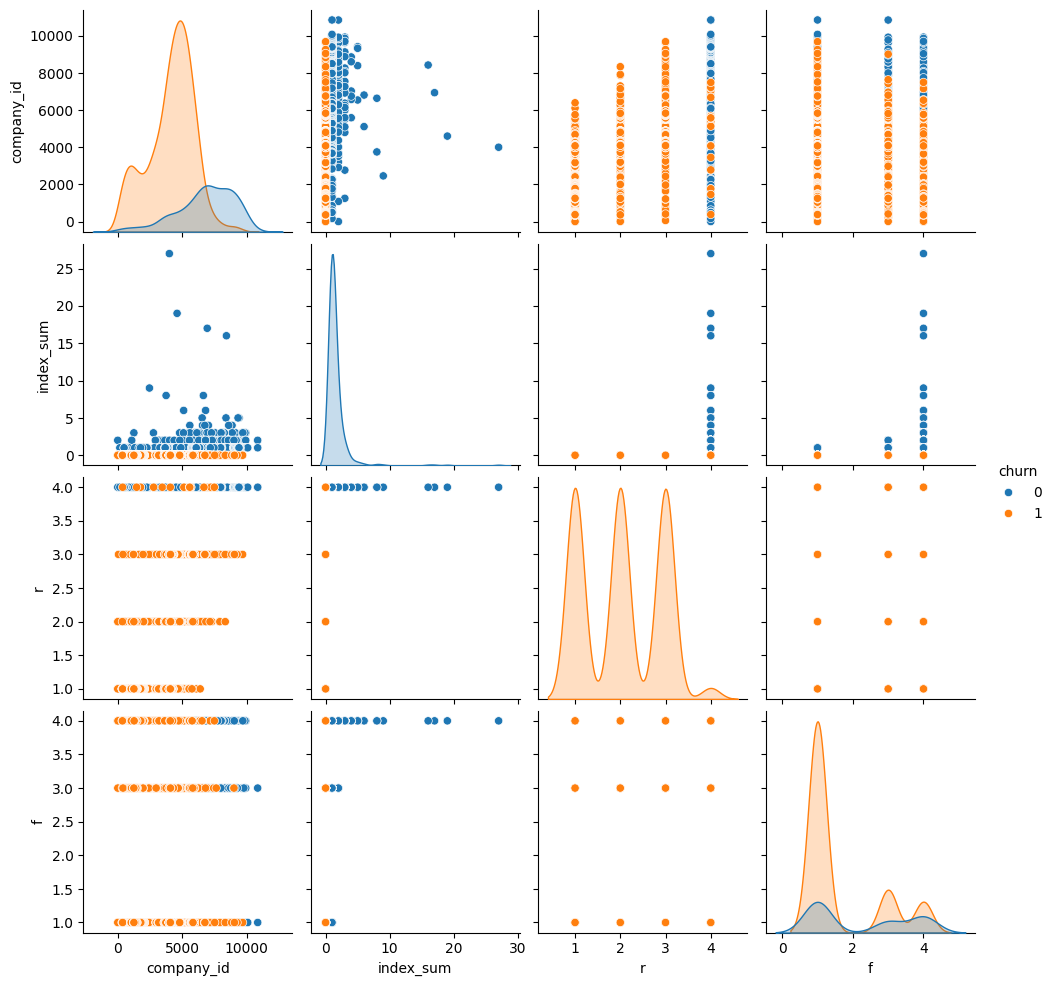

In [93]:
sns.pairplot(dataset, hue = 'churn',kind='scatter')# посмотрим как связаны распределение величин в зависимости друг от друга .Оранжевый цвет -компании в оттоке ,синия -остаются в сервисе

Объединим подготовленные датасеты в один, ключ-название компании

In [95]:

gectaro = df_сomp.merge(dataset,on = 'company_id').merge(df_act,on ='company_id').merge(df_pl_rol,on ='company_id')
gectaro.head()

,company_id,working_direction,employer_count_interval,created_at,billing_tariff_id,tariff_group,Стройка,Ремонт,max_until,index_sum,r,f,churn,activ_total,backups_sum,role_id
0,514,-,1.0,2019-10-17,4.0,старт,0,0,2019-12-29,0,1.0,1.0,1,5.0,0.0,1
1,383,Строительство,2.0,2019-07-26,7.0,старт,1,0,2024-03-16,0,4.0,1.0,1,19.0,0.0,3
2,495,-,1.0,2019-10-08,2.0,базовый,0,0,2024-09-01,1,4.0,4.0,0,49.0,11.0,8
3,724,-,1.0,2020-01-20,4.0,старт,0,0,2020-10-06,0,1.0,1.0,1,12.0,0.0,2
4,471,-,1.0,2019-09-24,7.0,старт,0,0,2020-12-12,0,1.0,1.0,1,27.0,0.0,3


Добавим столбец-время существования компании в системе(разница между датой последней подписки и регистрацией компании в системе)

In [96]:
gectaro['lifetime']= (gectaro['max_until']-gectaro['created_at'])/ np.timedelta64 ( 1 , 'D')
gectaro.head()

,company_id,working_direction,employer_count_interval,created_at,billing_tariff_id,tariff_group,Стройка,Ремонт,max_until,index_sum,r,f,churn,activ_total,backups_sum,role_id,lifetime
0,514,-,1.0,2019-10-17,4.0,старт,0,0,2019-12-29,0,1.0,1.0,1,5.0,0.0,1,73.0
1,383,Строительство,2.0,2019-07-26,7.0,старт,1,0,2024-03-16,0,4.0,1.0,1,19.0,0.0,3,1695.0
2,495,-,1.0,2019-10-08,2.0,базовый,0,0,2024-09-01,1,4.0,4.0,0,49.0,11.0,8,1790.0
3,724,-,1.0,2020-01-20,4.0,старт,0,0,2020-10-06,0,1.0,1.0,1,12.0,0.0,2,260.0
4,471,-,1.0,2019-09-24,7.0,старт,0,0,2020-12-12,0,1.0,1.0,1,27.0,0.0,3,445.0


Выделим из датасета числовые признаки,изучим их связь с целевой переменной корреляцией Пирсона.Построим матрицу корреляции и тепловую карту.

In [97]:
gectaro_num = gectaro[['churn','activ_total','lifetime','backups_sum','role_id','Стройка','Ремонт']]


In [98]:
gectaro_num.describe()

,churn,activ_total,lifetime,backups_sum,role_id,Стройка,Ремонт
count,706.000000,706.000000,706.000000,706.000000,706.000000,706.000000,706.000000
mean,0.655807,297.099150,583.886686,10.541076,7.208215,0.229462,0.059490
std,0.475441,779.490742,368.764260,33.211536,7.375673,0.420785,0.236707
min,0.000000,4.000000,7.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,33.000000,378.250000,0.000000,2.250000,0.000000,0.000000
50%,1.000000,92.500000,524.000000,0.000000,5.000000,0.000000,0.000000
75%,1.000000,281.750000,784.750000,0.000000,9.750000,0.000000,0.000000
max,1.000000,11060.000000,2272.000000,310.000000,55.000000,1.000000,1.000000


<Axes: >

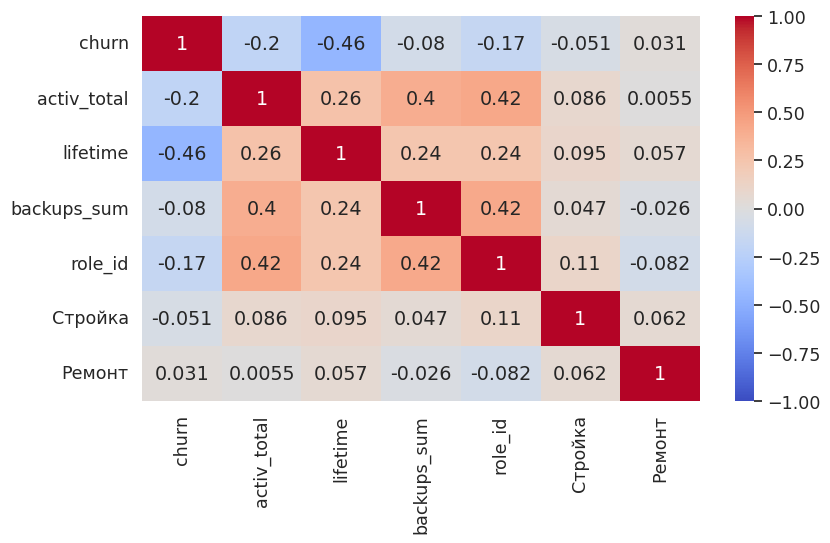

In [99]:
sns.set(font_scale=1.15)
plt.figure(figsize=(9,5))
sns.heatmap(
    gectaro_num.corr(),
    cmap= 'coolwarm',
    annot=True,
    vmin=-1, vmax=1,center= 0)

Есть некоторая связь между актвностями компании ,чем больше компания заказывает материалов ,аредует складов и делает проектов,тем меньше шансов на уход ее из сервиса.Такая же связь с количеством должностей в компаниях. Более ошутима связь между временем существования в системе и оттоком.Чем дольше в  системе ,тем скорее останется .

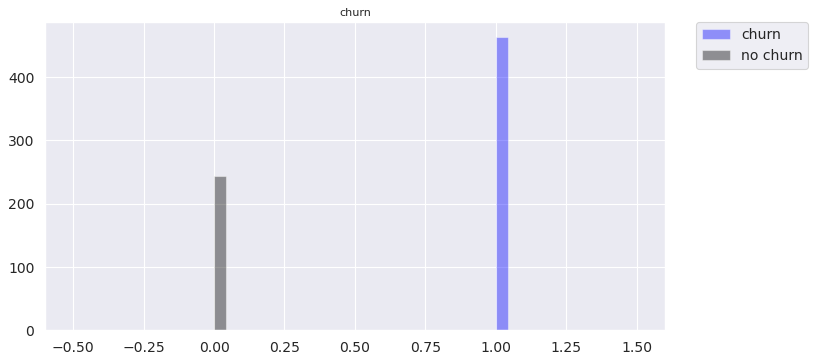

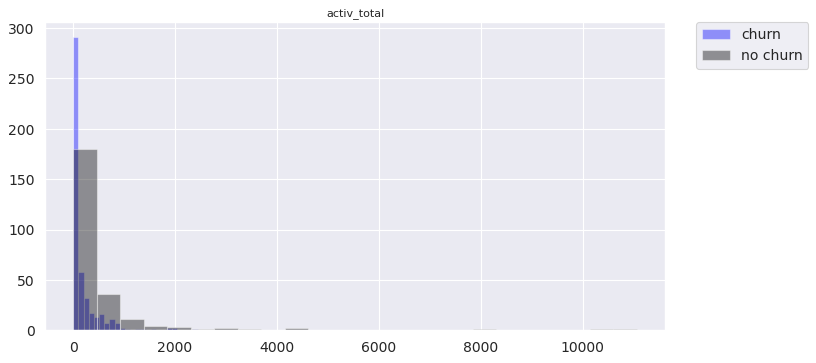

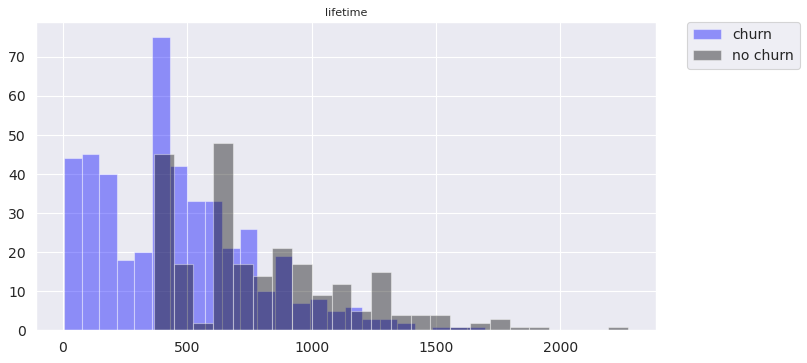

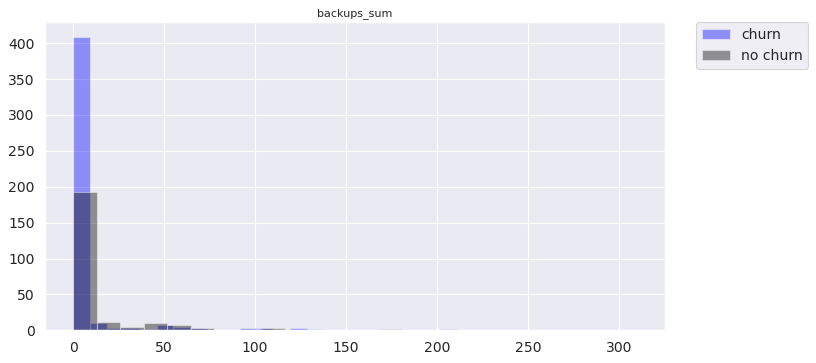

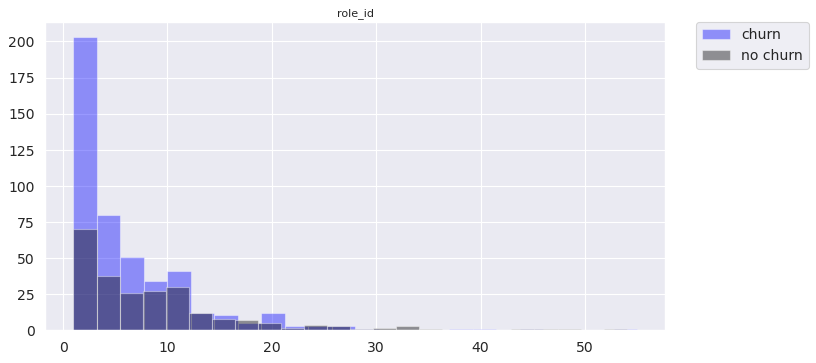

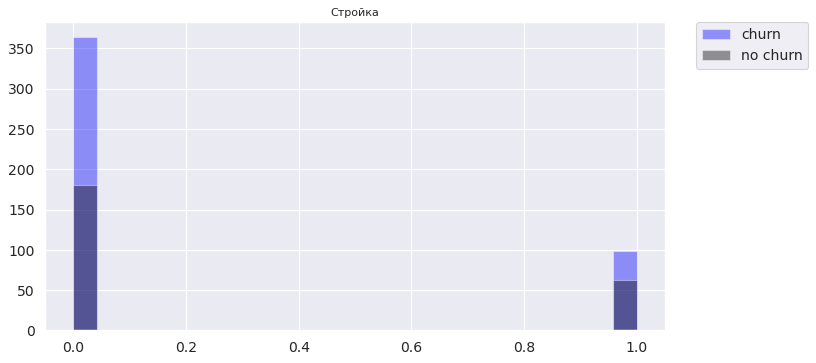

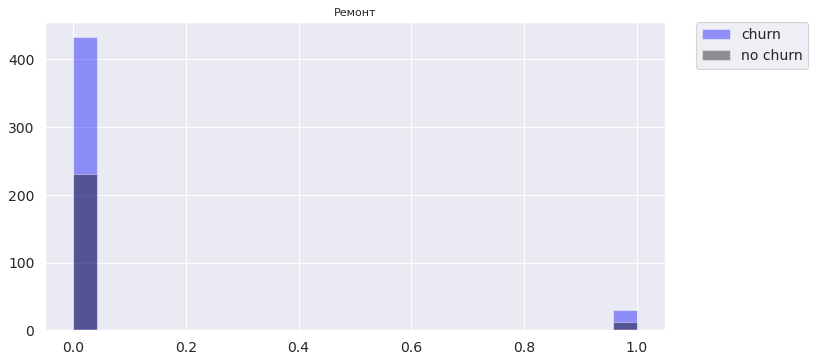

In [100]:
#Разбиваем данные на churn и нет
dif_1 = gectaro_num.query('churn == 1')
dif_0 = gectaro_num.query('churn == 0')

#Строим гистограмы через цикл

for feature in gectaro_num.columns:
    plt.figure(figsize=(10,5), dpi= 80)
    sns.distplot(dif_1[feature], bins = 24, kde = False, label="churn", color = 'blue')
    sns.distplot(dif_0[feature], bins = 24, kde = False, label="no churn", color = 'black')
    plt.legend(bbox_to_anchor=( 1.05 , 1 ), loc='upper left', borderaxespad= 0 )

    plt.title(feature, fontsize=10)
    plt.ylabel("")
    plt.xlabel("")
    plt.show()




По гистограммам видим ,что имеем распределения признаков не нормальные. Проверим критерием один из них lifetime


In [101]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(gectaro['lifetime'])
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  1.62523176204998e-14
Отвергаем нулевую гипотезу: распределение не нормально


Проверим выделенные количественные признаки

Сформулируем гипотезу:

  -  **Н0 Между группами churn и no_churn  с данным  признаком  нет различий в среднем**  (нулевая)       
  -  **Н1 Между группами churn и no_churn  с данным  признаком  есть различия в среднем** (альтернативная)

Так как распределения не нормальны , применим критерий Манна-Уитни

In [110]:
def test_mw(set1,set2):

    results = st.mannwhitneyu(set1,set2,True,'less')

    print('p-значение: ', results.pvalue)
    alpha = 0.05
    alpha_sid = 1-(1-alpha)**(1/6)# метод Шидака ,нужна поправка поскольку множественные сравнения
    if results.pvalue < alpha_sid:
        print(f'Отвергаем нулевую гипотезу: разница  в среднем отклике для выборок статистически значима')
    else:
        print(f'Не получилось отвергнуть нулевую гипотезу, вывод о различии в выборках сделать нельзя')

In [111]:
set1 = np.array(gectaro_num.query('churn == 1')['lifetime'])#проверяем признак liftime

set2 = np.array(gectaro_num.query('churn == 0')['lifetime'])
test_mw(set1,set2)

p-значение:  6.991366302693205e-35
Отвергаем нулевую гипотезу: разница  в среднем отклике для выборок статистически значима


In [112]:
set1 = np.array(gectaro_num.query('churn == 1')['activ_total'])#проверяем признак суммарной активности

set2 = np.array(gectaro_num.query('churn == 0')['activ_total'])
test_mw(set1,set2)

p-значение:  2.7209088275860117e-16
Отвергаем нулевую гипотезу: разница  в среднем отклике для выборок статистически значима


In [113]:
set1 = np.array(gectaro_num.query('churn == 1')['role_id'])#признак кол-ва должностей в компаниях

set2 = np.array(gectaro_num.query('churn == 0')['role_id'])
test_mw(set1,set2)

p-значение:  1.5326400977542378e-06
Отвергаем нулевую гипотезу: разница  в среднем отклике для выборок статистически значима


In [114]:
set1 = np.array(gectaro_num.query('churn == 1')['backups_sum'])#признак бэкап компании

set2 = np.array(gectaro_num.query('churn == 0')['backups_sum'])
test_mw(set1,set2)

p-значение:  1.3787880654371115e-05
Отвергаем нулевую гипотезу: разница  в среднем отклике для выборок статистически значима


In [115]:
set1 = np.array(gectaro_num.query('churn == 1')['Стройка'])#признак ,показывающий,что компания связан по роду деятельности со стоительством

set2 = np.array(gectaro_num.query('churn == 0')['Стройка'])
test_mw(set1,set2)

p-значение:  0.08646400861829545
Не получилось отвергнуть нулевую гипотезу, вывод о различии в выборках сделать нельзя


In [116]:
set1 = np.array(gectaro_num.query('churn == 1')['Ремонт'])#признак,показывающий,что компания занимается ремонтом

set2 = np.array(gectaro_num.query('churn == 0')['Ремонт'])
test_mw(set1,set2)

p-значение:  0.794580003228828
Не получилось отвергнуть нулевую гипотезу, вывод о различии в выборках сделать нельзя


###Вывод : на отток влияют количественные признаки-чем более активна компания,чем больше время пребывания в сервисе ,чем больше бэкапов делает компания ,чем больше должностей в компании ,тем реже компания уходит. Влияние деятельности компании на ее уход не прослеживается.

In [ ]:
gectaro_num.head()

Рассмотрим категориальные переменные и их влияние на отток.

Построим графики ,сравнивая отток по тарифам и в зависимости от численности компании.

In [102]:
gectaro_cat = gectaro[['company_id','billing_tariff_id','index_sum','r','f','churn','employer_count_interval','tariff_group']]
gectaro_cat.head()

,company_id,billing_tariff_id,index_sum,r,f,churn,employer_count_interval,tariff_group
0,514,4.0,0,1.0,1.0,1,1.0,старт
1,383,7.0,0,4.0,1.0,1,2.0,старт
2,495,2.0,1,4.0,4.0,0,1.0,базовый
3,724,4.0,0,1.0,1.0,1,1.0,старт
4,471,7.0,0,1.0,1.0,1,1.0,старт


Text(0, 0.5, 'Количество')

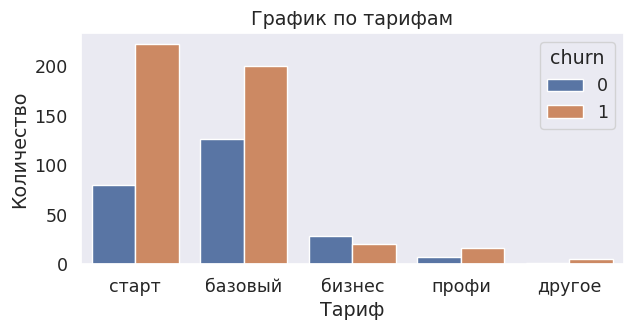

In [103]:
data_c =  gectaro.groupby(['tariff_group', 'churn'], \
                        as_index = False)[['company_id']].count().sort_values(by='company_id',ascending=False)
sns.set_style('dark')
plt.figure(figsize=(7, 3))
sns.barplot(x='tariff_group', y='company_id', data=data_c, hue='churn')
plt.title('График по тарифам')
plt.xlabel('Тариф')
plt.ylabel('Количество')

Text(0, 0.5, 'Количество')

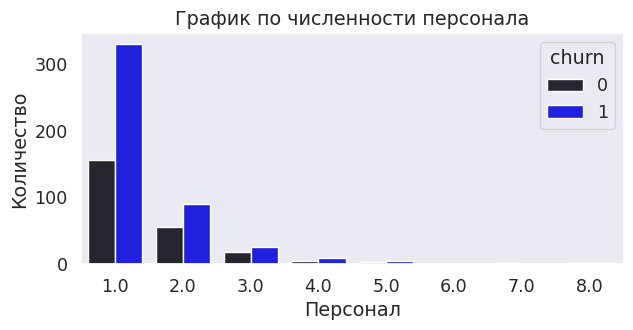

In [104]:
data_p =  gectaro.groupby(['employer_count_interval', 'churn'], \
                        as_index = False)[['company_id']].count().sort_values(by='company_id',ascending=False)
sns.set_style('dark')
sns.color_palette("Paired")
plt.figure(figsize=(7, 3))
sns.barplot(x='employer_count_interval', y='company_id', data=data_p, hue='churn',color='blue')
plt.title('График по численности персонала')
plt.xlabel('Персонал')
plt.ylabel('Количество')

Для исследования связи между рангами используем корреляцию Спирмена

In [105]:
from scipy.stats import spearmanr

def cor (set1,set2):

    rho, p = spearmanr(set1, set2)

#напечатаем ранговую корреляцию Спирмена и p-значение, порог = 0,05
    print(rho)
    print(p)

In [106]:
cor(gectaro['churn'],gectaro['r'])#Давность (r) связана с оттоком ,так как формируется  на основе сроков подписки

-0.8461385486568931
1.396506510549413e-194


Поскольку p-значение корреляции  меньше 0,05, корреляция  является статистически значимой.

In [107]:
cor(gectaro['churn'],gectaro['f'])# корреляция статистически значима ,отток зависит от частоты платежей



-0.1102154710965664
0.0033651978544067336


In [108]:
cor(gectaro['churn'],gectaro['billing_tariff_id'])# корреляция не является статистически значимой ,таким образом зависимость мы определить не можем



-0.013940055648663026
0.7115627249876517


In [109]:
cor(gectaro['churn'],gectaro['employer_count_interval'])#корреляция является статистически значимой



-0.07400725967269246
0.049340970854701495


###Вывод: на отток влияет давность ,частота платежей ,размер компании по численности персонала,причем чем выше ранг этих величин ,тем реже отток.

In [117]:
comp_low = gectaro[gectaro['r'] <= 2 ].reset_index(drop=True)# показатель в RFM анализе ,что клиенты склонны к оттоку
comp_low['churn'].describe()#здесь мы видим ,что клиенты все в оттоке уже.Такой анализ нам не очень информативен.


count    343.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: churn, dtype: float64

#Общие выводы:

Уход компаний зависит прежде всего от их размера,небольшие компании (с малым количеством сотрудников и малым количеством должностей) уходят чаще. Причем уходят преимущественно со Стартового тарифа,понимая ,что сервис им не подходит. Компания,которая проявляет большую активность(склады ,проекты и пр.),выбирает оптимальный тариф (активность в подписках)и уже долго находится в сервисе, уйдет менее вероятно.Это в основном крупные компании. Их прежде всего и надо привлекать.

https://drive.google.com/file/d/1Me0CM2Dk0t-MicSb-SWG8m5sVZbhQDZ7/view?usp=drive_link